# PSD Tool Tutorial

This notebook demonstrates how to use the `psd_tool` package to estimate Pore Radius Distribution from Cross-section radius Distribution.


In [17]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add src to path if package is not installed
sys.path.append(os.path.abspath('../src'))
from psd_tool import estimate_c, saltykov

## 1. Generate Synthetic Data
We will generate synthetic pore radii using a log-normal distribution and calculate the corresponding cross-section radius.

In [18]:
def chords(r,dx):
    chords=[]
    x=dx
    while x<2*r:
        chords.append(np.sqrt(r**2-(r-x)**2))
        x+=dx
    return chords
size = 1000
np.random.seed(42)
data = np.random.lognormal(mean=0, sigma=0.5, size=size)
r_range = (0.1, 10)
Pore_radius = data[(data >= r_range[0]) & (data <= r_range[1])]

chords_all = []
dx = 0.001
for r_sphere in Pore_radius:
    chords_all.extend(chords(r_sphere, dx))
chords_all = np.array(chords_all)

print(f"Generated {len(chords_all)} cross-section radius from {len(Pore_radius)} pores.")

Generated 2281426 cross-section radius from 1000 pores.


## 2. Estimate Pore Size Distribution
We use the `estimate_c` function to reconstruct the PSD from the chord lengths. Very small cross-section radius (smaller than 0.05) is discarded to simulate real measurements.


In [19]:
n_bins = 20
c, bins, residual = estimate_c(
    chords_all[chords_all >= 0.05], 
    r_min=0.05, 
    cutoff=1, 
    num_bins=n_bins, 
    linear=False
)

print("Residual norm:", residual)


Residual norm: 1.7570119828847813e-06


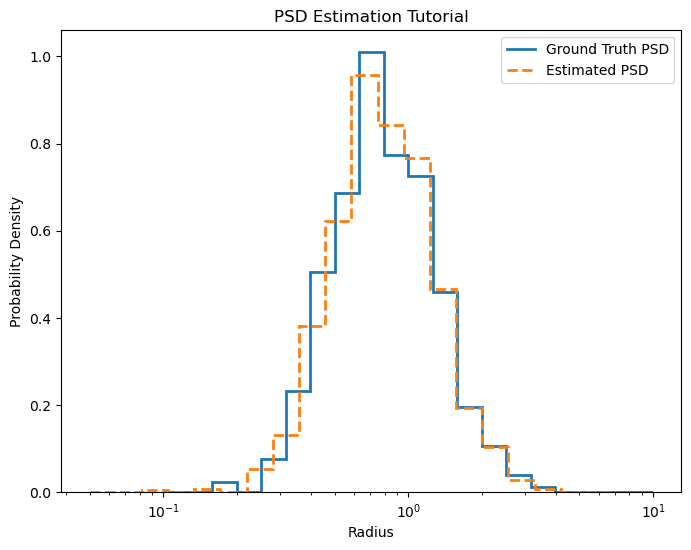

In [20]:
plt.figure(figsize=(8, 6))

# Ground Truth
bin_edges = np.logspace(np.log10(r_range[0]), np.log10(r_range[1]), num=n_bins+1)
Pore_radius_density, _ = np.histogram(Pore_radius, bin_edges, density=True)
plt.stairs(Pore_radius_density, bin_edges, fill=False, label='Ground Truth PSD', linewidth=2)

# Estimated
plt.stairs(c, bins, fill=False, label='Estimated PSD', linewidth=2, linestyle='--')

plt.xscale('log')
plt.xlabel('Radius')
plt.ylabel('Probability Density')
plt.legend()
plt.title('PSD Estimation Tutorial')
plt.show()


## 3. Compare with Saltikov method
We compare our method against Saltikov method using the same number of log-spaced binning

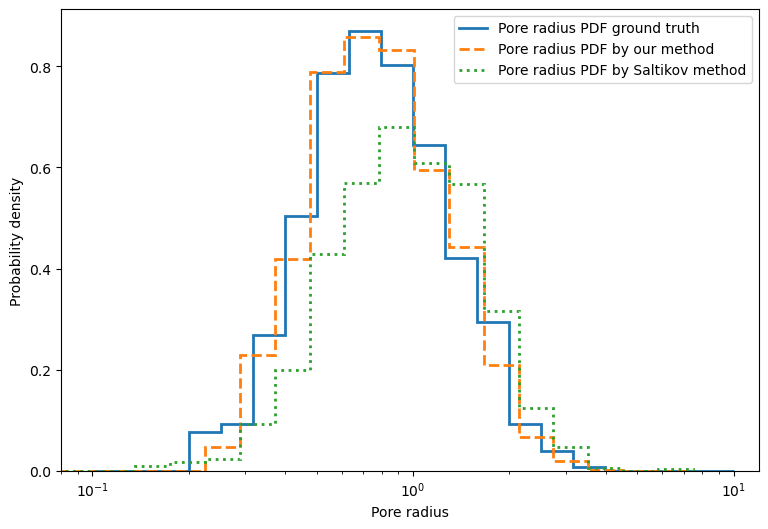

In [21]:
size = 1000   # Number of samples
n_bins = 20    # Number of bins for histogram
r_range = (0.1, 10)# Range of x
bin_edges = np.logspace(np.log10(r_range[0]), np.log10(r_range[1]), num=n_bins+1)
#bin_edges = np.linspace(r_range[0], r_range[1], num=n_bins+1)
np.random.seed(24)
data=np.random.lognormal(mean=0,sigma=0.5,size=size)
Pore_radius = data[(data >= r_range[0]) & (data <= r_range[1])]

def chords(r,dx):
    chords=[]
    x=dx
    while x<2*r:
        chords.append(np.sqrt(r**2-(r-x)**2))
        x+=dx
    return chords
chords_all=[]
dx=0.01
for r_sphere in Pore_radius:
    chords_all.extend(chords(r_sphere,dx))
chords_all=np.array(chords_all)

r_range_rev = (0.1, 10)

c,bins,residual=estimate_c(chords_all[chords_all>=0.05],r_min=0.05,cutoff=1,num_bins=n_bins,linear=False)

# Output the result
plt.style.use('default')
plt.figure(figsize=(9, 6))
Pore_radius_density,_=np.histogram(Pore_radius,bin_edges,density=True)
plt.stairs(Pore_radius_density, bin_edges,fill=False,label='Pore radius PDF ground truth', linewidth=2)
plt.stairs(c,bins,fill=False,label="Pore radius PDF by our method",linewidth=2, ls='--')
# Saltikov method

mid_points, edges,probdensity=Saltykov(
    diameters=chords_all[chords_all>=0.05],
    numbins=20,
    log_scale=True,
    return_data=True
)
plt.stairs(probdensity,edges, fill=False, label="Pore radius PDF by Saltikov method",linewidth=2, ls=':')
plt.xlim([0.08,12])
plt.xscale('log')
plt.legend()
plt.xlabel('Pore radius')
plt.ylabel('Probability density')
plt.show()

## 3. Apply experimental data
We will import experimentally measured cross-section radius distribution and convert it into pore radius distribution. The details related to how the cross-section radius is measured can be found in article "A new method to measure pore radius distribution of powders".

In [22]:
# Load data
import csv
folder=os.path.join("..","data")
samplenames=["003","005","039","040"]
csd_all={}
for count,samplename in enumerate(samplenames):
    radius=[]
    for batch in ['1','2','3']:
        filepath=os.path.join(folder,f"{samplename}-{batch}_radius.csv")
        with open(filepath, newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                row.pop(0)
                for item in row:
                    radius.append(float(item))
    csd_all[count+1]=radius

In [23]:
# Estimate c for each sample
r_min=0.25
num_bins=50
cutoff=1
lin=False
c_all={}
samplenumbers=[1,2,3,4]
for samplenumber in samplenumbers:
    c_all[samplenumber]=estimate_c(csd_all[samplenumber],r_min=r_min,cutoff=cutoff,num_bins=num_bins,linear=lin)

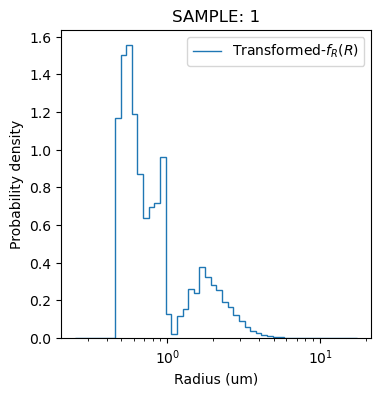

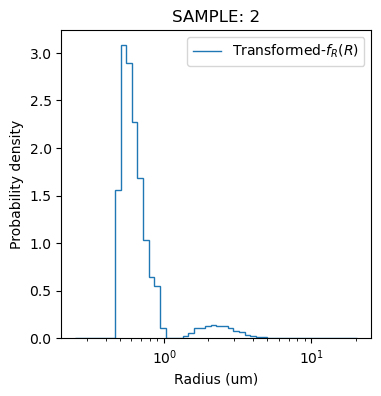

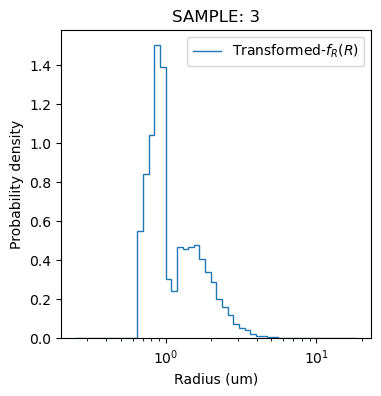

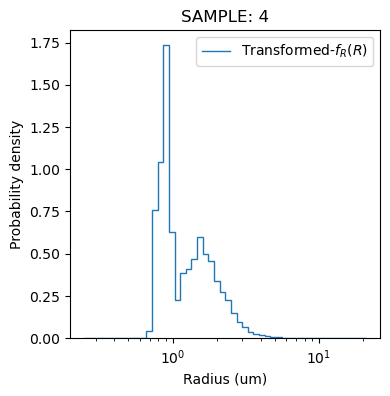

In [26]:
for count, samplenumber in enumerate(samplenumbers):
    # determine the bin edge position based on chord size distribution
    csd=csd_all[samplenumber]
    if lin:
        bin_edges = np.linspace(max(min(csd),r_min), max(csd), num=num_bins+1)
    else:
        bin_edges = np.logspace(np.log10(max(min(csd),r_min)), np.log10(max(csd)), num=num_bins+1)
    chord_density,_=np.histogram(csd,bins=bin_edges,density=True)
    plt.figure(figsize=(4, 4))
    plt.stairs(c_all[samplenumber][0], c_all[samplenumber][1],fill=False,label="Transformed-$f_R(R)$")
    plt.ylabel("Probability density")
    plt.xlabel("Radius (um)")
    plt.title(f"SAMPLE: {samplenumber}")
    if lin:
        pass
    else:
        plt.xscale('log')
    plt.legend()
    plt.show()